In [49]:
import os
import gensim
from gensim import corpora
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
import collections
import json
import time
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from gensim.models import TfidfModel


In [ ]:
# 确保工作目录正确
os.chdir('/Users/jessie/Documents/Projects/Cusanus_Topic_Modeling')


In [ ]:
# Step 1: 设置日志记录
log_dir = 'experiments/lda_baseline'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)  # 如果 notebooks 目录不存在则创建

log_path = os.path.join(log_dir, 'lda_testset_analysis.log')

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_path),  # 将日志保存到 notebooks 文件夹中
        logging.StreamHandler()
    ]
)

logging.info("启动 LDA 主题建模分析（基线模型）")


In [54]:
testset_dir = 'data/testset'
testset_files = [os.path.join(testset_dir, f) for f in os.listdir(testset_dir) if f.endswith('.txt')]
documents = []

# 读取每个测试集文档内容
for file_path in tqdm(testset_files, desc="加载测试集文档"):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().split()  # 直接读取单词列表
        documents.append(content)

logging.info(f"从测试集加载了 {len(documents)} 个文档")

加载测试集文档: 100%|██████████| 61/61 [00:00<00:00, 5154.06it/s]
2024-11-10 02:40:37,082 - INFO - 从测试集加载了 61 个文档


In [55]:
# Step 4: 创建字典和语料库（用于 LDA）
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text) for text in documents]

logging.info("创建了 LDA 所需的词典和语料库")

print("词典大小：", len(dictionary))
print("语料库大小：", len(corpus))

2024-11-10 02:40:38,205 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2024-11-10 02:40:38,228 - INFO - built Dictionary<9286 unique tokens: ['abicio', 'abscido', 'achaia', 'actus', 'adae']...> from 61 documents (total 52171 corpus positions)
2024-11-10 02:40:38,229 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<9286 unique tokens: ['abicio', 'abscido', 'achaia', 'actus', 'adae']...> from 61 documents (total 52171 corpus positions)", 'datetime': '2024-11-10T02:40:38.229160', 'gensim': '4.3.3', 'python': '3.10.15 (main, Oct  3 2024, 02:24:49) [Clang 14.0.6 ]', 'platform': 'macOS-15.1-arm64-arm-64bit', 'event': 'created'}
2024-11-10 02:40:38,244 - INFO - 创建了 LDA 所需的词典和语料库


词典大小： 9286
语料库大小： 61


2024-11-10 02:48:15,265 - INFO - collecting document frequencies
2024-11-10 02:48:15,267 - INFO - PROGRESS: processing document #0
2024-11-10 02:48:15,279 - INFO - TfidfModel lifecycle event {'msg': 'calculated IDF weights for 61 documents and 5917 features (12566 matrix non-zeros)', 'datetime': '2024-11-10T02:48:15.279739', 'gensim': '4.3.3', 'python': '3.10.15 (main, Oct  3 2024, 02:24:49) [Clang 14.0.6 ]', 'platform': 'macOS-15.1-arm64-arm-64bit', 'event': 'initialize'}


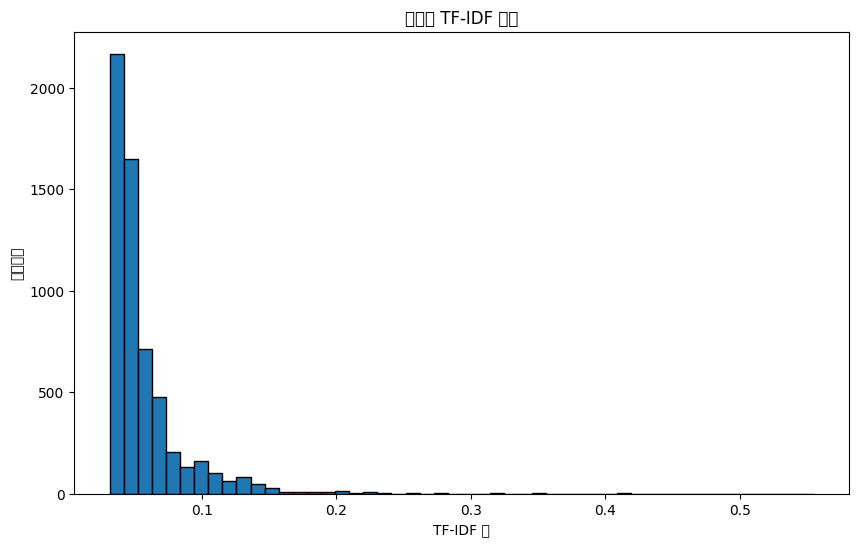

2024-11-10 02:48:15,421 - INFO - 已去除的通用词列表（基于TF-IDF）已保存到 'removed_common_words_tfidf.txt'
2024-11-10 02:48:15,447 - INFO - 基于TF-IDF的通用词过滤完成，生成新的语料库和字典


词典大小： 5917
语料库大小： 61


In [59]:
# 创建TF-IDF模型
tfidf = TfidfModel(corpus)  # corpus是包含所有文档的Bag-of-Words表示

# 计算每个词的平均TF-IDF值
word_tfidf = collections.defaultdict(float)
word_counts = collections.defaultdict(int)

for doc in corpus:
    tfidf_weights = tfidf[doc]
    for word_id, tfidf_value in tfidf_weights:
        word_tfidf[word_id] += tfidf_value
        word_counts[word_id] += 1

# 计算每个词的平均TF-IDF
average_tfidf = {word_id: total_tfidf / word_counts[word_id] for word_id, total_tfidf in word_tfidf.items()}

# 可视化 TF-IDF 分布
tfidf_values = list(average_tfidf.values())
plt.figure(figsize=(10, 6))
plt.hist(tfidf_values, bins=50, edgecolor='k')
plt.xlabel('TF-IDF 值')
plt.ylabel('词汇数量')
plt.title('词汇的 TF-IDF 分布')
plt.show()

# 设置TF-IDF的阈值，选择低于此阈值的词作为通用词
tfidf_threshold = 0.03  # 你可以根据具体语料情况调整阈值
common_words = {dictionary[word_id] for word_id, avg_tfidf in average_tfidf.items() if avg_tfidf < tfidf_threshold}

# 保存已去除的通用词到文件
with open("removed_common_words_tfidf.txt", "w", encoding="utf-8") as f:
    for word in common_words:
        f.write(word + "\n")

logging.info("已去除的通用词列表（基于TF-IDF）已保存到 'removed_common_words_tfidf.txt'")

# 过滤通用词，生成新的 `filtered_corpus`
filtered_corpus = [
    [(id, freq) for id, freq in doc if dictionary[id] not in common_words]
    for doc in corpus
]

# 更新字典以去除通用词
dictionary.filter_tokens(bad_ids=[dictionary.token2id[word] for word in common_words if word in dictionary.token2id])
dictionary.compactify()  # 确保字典的ID连续

# 重新生成语料库
filtered_corpus = [dictionary.doc2bow(text) for text in documents]

logging.info("基于TF-IDF的通用词过滤完成，生成新的语料库和字典")

print("词典大小：", len(dictionary))
print("语料库大小：", len(corpus))

In [61]:
# 设置可能的 alpha 和 eta 值
alpha_values = [0.01, 0.05, 0.1]
eta_values = [0.01, 0.05, 0.1]

# 存储每次运行的结果
results = []

# 定义实验参数
num_topics = 10
passes = 50
iterations = 200

# 遍历 alpha 和 eta 的所有组合
for alpha in alpha_values:
    for eta in eta_values:
        # 训练 LDA 模型
        lda_model = gensim.models.LdaModel(
            corpus=filtered_corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=passes,
            iterations=iterations,
            alpha=alpha,
            eta=eta
        )

        # 计算主题一致性（NPMI）
        coherence_model_npmi = CoherenceModel(
            model=lda_model,
            texts=documents,  # 使用去除通用词后的文本
            dictionary=dictionary,
            coherence='c_npmi'
        )
        avg_npmi = coherence_model_npmi.get_coherence()

        # 计算主题多样性
        unique_words = set()
        total_words = 0
        for topic in lda_model.show_topics(num_topics=num_topics, num_words=20, formatted=False):
            words = [word for word, _ in topic[1]]
            unique_words.update(words)
            total_words += len(words)
        topic_diversity = len(unique_words) / total_words

        # 将结果存储到列表中
        results.append({
            'alpha': alpha,
            'eta': eta,
            'avg_npmi': avg_npmi,
            'topic_diversity': topic_diversity
        })

        # 输出当前结果
        logging.info(f"Alpha: {alpha}, Eta: {eta}, Avg NPMI: {avg_npmi:.4f}, Topic Diversity: {topic_diversity:.2f}")

# 找到最优的组合参数
best_result = max(results, key=lambda x: (x['avg_npmi'], x['topic_diversity']))

# 输出所有组合的结果
for result in results:
    print(f"Alpha: {result['alpha']}, Eta: {result['eta']}, Avg NPMI: {result['avg_npmi']:.4f}, Topic Diversity: {result['topic_diversity']:.2f}")

# 输出最优结果
print(f"\n最优结果: Alpha: {best_result['alpha']}, Eta: {best_result['eta']}, Avg NPMI: {best_result['avg_npmi']:.4f}, Topic Diversity: {best_result['topic_diversity']:.2f}")

# 创建唯一实验ID和目录
experiment_id = f"lda_experiment_{int(time.time())}"
experiment_dir = os.path.join('experiments', experiment_id)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# 保存最优参数设置
params = {
    "num_topics": num_topics,
    "passes": passes,
    "iterations": iterations,
    "alpha": best_result['alpha'],
    "eta": best_result['eta']
}
params_path = os.path.join(experiment_dir, 'params.json')
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)
logging.info(f"最优参数设置已保存至 {params_path}")

# 训练最优参数的 LDA 模型
lda_model = gensim.models.LdaModel(
    corpus=filtered_corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=passes,
    iterations=iterations,
    alpha=best_result['alpha'],
    eta=best_result['eta']
)

# 保存主题词和评估结果到一个文件
results_file_path = os.path.join(experiment_dir, 'lda_results.txt')
with open(results_file_path, 'w', encoding='utf-8') as f:
    # 保存主题词
    f.write("LDA 生成的主题：\n")
    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
        topic_str = f"Topic {idx}: {topic}"
        f.write(topic_str + '\n')
    f.write("\n")

    # 保存评估结果
    f.write(f"困惑度: {lda_model.log_perplexity(filtered_corpus)}\n")
    f.write(f"主题一致性 (NPMI): {best_result['avg_npmi']}\n")
    f.write(f"主题多样性: {best_result['topic_diversity']}\n")

logging.info(f"主题词和评估结果已保存至 {results_file_path}")

# 保存文档的主题分配情况
doc_topic_distributions = []
for i, doc in enumerate(filtered_corpus):
    doc_topics = lda_model.get_document_topics(doc)
    for topic_id, prob in doc_topics:
        doc_topic_distributions.append({
            "Document": os.path.basename(testset_files[i]),
            "Topic": topic_id,
            "Probability": prob
        })

csv_output_path = os.path.join(experiment_dir, 'document_topic_distributions.csv')
topic_distributions_df = pd.DataFrame(doc_topic_distributions)
topic_distributions_df.to_csv(csv_output_path, index=False)
logging.info(f"文档的主题分配情况已保存至: {csv_output_path}")

# 保存 pyLDAvis 可视化
lda_visualization = gensimvis.prepare(lda_model, filtered_corpus, dictionary, n_jobs=1)
pyldavis_path = os.path.join(experiment_dir, 'lda_visualization.html')
pyLDAvis.save_html(lda_visualization, pyldavis_path)
logging.info(f"pyLDAvis 可视化已保存至: {pyldavis_path}")

print(f"\n最优结果已保存到: {experiment_dir}")

2024-11-10 02:51:32,487 - INFO - using serial LDA version on this node
2024-11-10 02:51:32,494 - INFO - running online (multi-pass) LDA training, 10 topics, 50 passes over the supplied corpus of 61 documents, updating model once every 61 documents, evaluating perplexity every 61 documents, iterating 200x with a convergence threshold of 0.001000
2024-11-10 02:51:32,579 - INFO - -17.042 per-word bound, 134967.7 perplexity estimate based on a held-out corpus of 61 documents with 23475 words
2024-11-10 02:51:32,579 - INFO - PROGRESS: pass 0, at document #61/61
2024-11-10 02:51:32,645 - INFO - topic #8 (0.010): 0.014*"forma" + 0.014*"virtus" + 0.012*"rex" + 0.011*"oboedio" + 0.010*"dominus" + 0.010*"gloria" + 0.007*"sentio" + 0.006*"iesus" + 0.006*"audio" + 0.006*"voluntas"
2024-11-10 02:51:32,645 - INFO - topic #0 (0.010): 0.030*"lumen" + 0.026*"lux" + 0.019*"virtus" + 0.010*"moueo" + 0.009*"lucus" + 0.008*"forma" + 0.008*"ars" + 0.007*"iudico" + 0.007*"sol" + 0.006*"amor"
2024-11-10 02:51

Alpha: 0.01, Eta: 0.01, Avg NPMI: -0.2316, Topic Diversity: 0.54
Alpha: 0.01, Eta: 0.05, Avg NPMI: -0.2285, Topic Diversity: 0.54
Alpha: 0.01, Eta: 0.1, Avg NPMI: -0.2299, Topic Diversity: 0.54
Alpha: 0.05, Eta: 0.01, Avg NPMI: -0.2338, Topic Diversity: 0.54
Alpha: 0.05, Eta: 0.05, Avg NPMI: -0.2264, Topic Diversity: 0.53
Alpha: 0.05, Eta: 0.1, Avg NPMI: -0.2299, Topic Diversity: 0.54
Alpha: 0.1, Eta: 0.01, Avg NPMI: -0.2333, Topic Diversity: 0.53
Alpha: 0.1, Eta: 0.05, Avg NPMI: -0.2294, Topic Diversity: 0.53
Alpha: 0.1, Eta: 0.1, Avg NPMI: -0.2294, Topic Diversity: 0.54

最优结果: Alpha: 0.05, Eta: 0.05, Avg NPMI: -0.2264, Topic Diversity: 0.53


2024-11-10 02:52:21,721 - INFO - -8.169 per-word bound, 287.8 perplexity estimate based on a held-out corpus of 61 documents with 23475 words
2024-11-10 02:52:21,722 - INFO - PROGRESS: pass 2, at document #61/61
2024-11-10 02:52:21,732 - INFO - topic #3 (0.050): 0.031*"dies" + 0.019*"ars" + 0.010*"virgo" + 0.010*"adam" + 0.009*"ordo" + 0.009*"initium" + 0.008*"orior" + 0.007*"dominus" + 0.007*"sol" + 0.006*"animalitas"
2024-11-10 02:52:21,732 - INFO - topic #8 (0.050): 0.016*"forma" + 0.013*"rex" + 0.012*"oboedio" + 0.011*"gloria" + 0.010*"dominus" + 0.008*"virtus" + 0.008*"iesus" + 0.008*"sentio" + 0.007*"leprosus" + 0.006*"traho"
2024-11-10 02:52:21,733 - INFO - topic #4 (0.050): 0.016*"mare" + 0.012*"dominus" + 0.011*"mater" + 0.011*"sapientia" + 0.009*"sacramentum" + 0.009*"virgo" + 0.008*"mulier" + 0.008*"adam" + 0.007*"semen" + 0.007*"angelus"
2024-11-10 02:52:21,733 - INFO - topic #5 (0.050): 0.026*"virtus" + 0.011*"dominus" + 0.011*"caritas" + 0.011*"fecunditas" + 0.010*"iesus"


最优结果已保存到: experiments/lda_experiment_1731203541
